In [1]:
from IPython.core.interactiveshell import InteractiveShell
import pandas as pd
import numpy as np
from joblib import dump
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neural_network import MLPClassifier
#
# from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score
# from sklearn.metrics import accuracy_score, precision_recall_curve, plot_roc_curve, plot_confusion_matrix
# from sklearn.metrics import SCORERS, plot_precision_recall_curve
from sklearn.metrics import *
from sklearn.utils import parallel_backend
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer

from matplotlib import pyplot as plt
%matplotlib inline

InteractiveShell.ast_node_interactivity = "all"

# Constants
SEED = 87654

# Functions


def post_est(est, preds, x_test, y_test, plots=True):

    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

    print("Confusion matrix:\n", confusion_matrix(
        y_test, preds, normalize='all'))
    print(classification_report(y_test, preds))
    print('ROC AUC score:', round(roc_auc_score(y_test, preds), 2))
    print('Avg precision score:', round(
        average_precision_score(y_test, preds), 2))
    print('Specificity:', round(tn / (tn + fp), 2))
    print('Sensitivity (recall):', round(tp / (tp + fn), 2))
    # print(round((tn, fp, fn, tp) / (tn+fp+fn+tp), 2))

    if(plots == True):
        ConfusionMatrixDisplay.from_estimator(
            est, x_test, y_test, normalize='all')
        RocCurveDisplay.from_estimator(est, x_test, y_test)
        PrecisionRecallDisplay.from_estimator(est, x_test, y_test)

In [2]:
%pwd

'/Volumes/GoogleDrive/.shortcut-targets-by-id/0B_l91_X4oq12MUZRS1UzVHFSem1HSEpqTE9oQjIxQQ/AXDD/Non-Service Work/Innovation/Retention Task Force/rtf_freefall/OMAD_adverse_outcome_mod/src_py'

In [24]:
data = pd.read_csv('../data/ALL-STU-transformed-data-to-py.csv',
                   na_values=['NA', 'NaN', 'Inf', '-Inf'])
# cat_var_list = []
# with open('../data/cat-var-list.txt', 'r') as f:
#     for line in f.read().splitlines():
#         cat_var_list.append(line)

num_var_list = ['tenth_day_credits', 'num_courses', 'pts',
                'attmp', 'nongrd', 'qgpa', 'tot_creds',
                'cum.pts', 'cum.attmp', 'cum.gpa', 'age', 'trans_gpa',
                'high_sch_gpa', 'major.change.count', 'n.major.courses',
                'csum.major.courses', 'avg.class.size', 'sum.fees',
                'csum.rep.courses', 'csum.w', 'csum.alt.grading',
                'stem.courses', 'stem.credits', 'avg.stem.grade',
                'csum.stem.courses', 'csum.stem.credits', 'ft.creds.ou',
                'rundiff', 'n.majors','hs_yrs_arts', 'hs_yrs_english', 
                'hs_yrs_for_lang', 'hs_yrs_math', 'hs_yrs_science', 'hs_yrs_soc_sci']

cat_var_list = ['class', 'honors_program',  'scholarship_type', 'yearly_honor_type',
                'qgpa15', 'qgpa20', 'probe', 'eop', 
                'athletics', 's1_gender', 'child_of_alum', 'running_start', 
                'resident', 'conditional', 'provisional', 'with_distinction', 
                'res_in_question', 'low_family_income', 'hs_def_arts', 
                'hs_def_english', 'hs_def_for_lang', 'hs_def_math', 
                'hs_def_science', 'hs_def_soc_sci', 'hs_for_lang_type', 
                'hs_for_lang_yrs', 'hs_math_level', 'last_school_type', 
                'reg.late.binary', 'major.change', 
                'dual_major', 'premajor', 'ext_premajor', 'nonmatric']


if 'Unnamed: 0' in data.columns:
    data.drop(columns='Unnamed: 0', inplace=True)

data.dropna(subset=['Y'], inplace=True)
data = data[data['class'] <= 4]

# def recode_cats(df, var_list):
#     for x in var_list:
#         df = pd.concat([df, pd.get_dummies(df[x],
#                                            prefix = x,
#                                            dummy_na = False,
#                                            drop_first = True)],  # check this opt depending on model(s)
#                       axis = 1).drop([x], axis = 1)
#     return(df)

# data = recode_cats(data, cat_var_list)
# variables to exclude from model:
id_vars = ['system_key', 'yrq', 'tran_major_abbr']
target = 'Y'
x_vars = [x for x in data.columns if x not in [target]]
x_vars = [x for x in x_vars if x not in id_vars]

x_train, x_test, y_train, y_test = train_test_split(data[x_vars],
                                                    data[target],
                                                    test_size=0.25,
                                                    random_state=SEED,
                                                    stratify=data[target])

In [25]:
# is data balanced? Or, how badly unbalanced is data?
data['Y'].value_counts() / data.shape[0]

0.0    0.695509
1.0    0.304491
Name: Y, dtype: float64

In [5]:
# transformer for tran_major_abbr
# maj_xform = Pipeline(steps=[
#     ('ohe_major', OneHotEncoder(drop=None, min_frequency=20, handle_unknown='ignore'))])

TypeError: __init__() got an unexpected keyword argument 'min_frequency'

In [26]:
cat_tran = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value=-1)),
    ('onehot', OneHotEncoder(drop=None, handle_unknown='ignore'))
])

num_tran = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_tran, num_var_list),
        ('cat', cat_tran, cat_var_list)
    ])

In [27]:
nn_steps = [  # ('cat_transformer', cat_transformer),
    # ('scaler', col_tran),
    # ('cat_impute', cat_impute),
    # ('ohe', cat_ohe),
    # ('impute', IterativeImputer()),
    # ('impute', SimpleImputer(strategy = 'mean')),
    # in my simple tests on a small slice of data mean imputation outperformed multiple imputation
    # with the advantage of being massively faster
    ('preprocessor', preprocessor),
    ('nnet', MLPClassifier())]
nn_pipe = Pipeline(nn_steps, verbose=True)

In [ ]:
# cv5 = cross_val_score(nn_pipe,
#                       x_train,
#                       y_train,
#                       cv = 5,
#                       scoring = 'f1_macro',
#                       n_jobs = -1,
#                       verbose = 2)

# cv5

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  4.3min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.3min finished


array([0.80715665, 0.80533844, 0.80632524, 0.80770303, 0.80644794])

In [18]:
# cv_ = cross_validate(
#     nn_pipe, x_train, y_train,
#     return_estimator=True, n_jobs=-1
# )

/Users/zane/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zane/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 3621, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 136, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 163, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 5198, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable

In [ ]:
# sum(cv_['test_score']) / len(cv_['test_score'])

0.8122141417681592

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=  11.4s
[Pipeline] .............. (step 2 of 2) Processing nnet, total=26.1min


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer())]),
                                                  ['tenth_day_credits',
                                                   'num_courses', 'pts',
                                                   'attmp', 'nongrd', 'qgpa',
                                                   'tot_creds', 'cum.pts',
                                                   'cum.attmp', 'cum.gpa',
                                                   'age', 'trans_gpa',
                                                   'high_sch_gpa',
                                                   'major.change.count'

Confusion matrix:
 [[0.61010063 0.08540897]
 [0.09434467 0.21014573]]
              precision    recall  f1-score   support

         0.0       0.87      0.88      0.87    181978
         1.0       0.71      0.69      0.70     79669

    accuracy                           0.82    261647
   macro avg       0.79      0.78      0.79    261647
weighted avg       0.82      0.82      0.82    261647

ROC AUC score: 0.78
Avg precision score: 0.59
Specificity: 0.88
Sensitivity (recall): 0.69


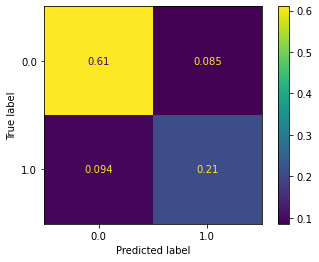

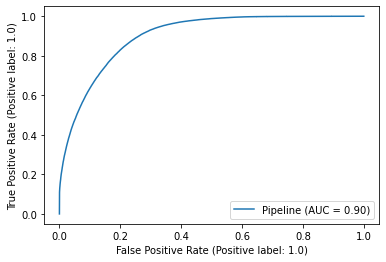

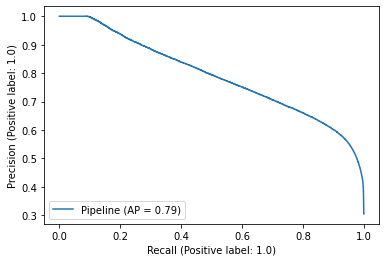

In [29]:
with parallel_backend('loky'):
    nn_pipe.set_params(nnet__alpha=.0001,
                       # {‘identity’, ‘logistic’, ‘tanh’, ‘relu’}
                       nnet__activation='logistic',
                       nnet__early_stopping=True,
                       nnet__hidden_layer_sizes=(400, 400, 400),
                       nnet__max_iter=1000,
                       nnet__verbose=False).fit(x_train, y_train)

    # mlp = MLPClassifier(hidden_layer_sizes = (236, 236, 236), max_iter = 500)

# joblib.dump(pipe, 'mods/fitted-test-nnet-pipe.sav')

preds = nn_pipe.predict(x_test)
predsa = nn_pipe.predict_proba(x_test)
resid = y_test - preds

post_est(nn_pipe, preds, x_test, y_test)

In [30]:
dump(nn_pipe, '../models/fitted-nnet-activation-logistic.joblib')

['../models/fitted-nnet-activation-logistic.joblib']

In [16]:
# check_results.to_csv("../data-preds/post_est_eda-12212021.csv", index=False, na_rep="NA")

NameError: name 'check_results' is not defined

In [ ]:
# new_data = pd.read_csv('../data/new-data-to-predict.csv', na_values=['NA', 'NaN', 'Inf', '-Inf'])

# # new_data = recode_cats(new_data, cat_var_list)
# new_x_vars = [x for x in new_data.columns if x not in [target]]
# new_x_vars = [x for x in new_x_vars if x not in id_vars]
# new_x = new_data[new_x_vars]
# # missing_vars = [x for x in x_vars if x not in new_x_vars]
# # missing_vars = dict((x, np.nan) for x in missing_vars)

# new_preds = nn_pipe.predict(new_x)
# new_predsa = nn_pipe.predict_proba(new_x)
# plt.hist(new_predsa[:,1])

In [ ]:
# nn_pipe.named_steps.nnet.n_iter_

25

In [ ]:
# nn_pipe.named_steps.nnet.coefs_
# nn_pipe.named_steps.nnet.intercepts_

[array([-0.13583891, -0.09543208, -0.02873381, -0.05708592,  0.0557553 ,
        -0.12879323, -0.0115567 , -0.08840312, -0.09364782, -0.16756171,
         0.05904674, -0.16592225, -0.03607791, -0.10513658, -0.06960966,
        -0.0712508 , -0.04290611, -0.05006696,  0.07507336, -0.04579918,
        -0.05575886, -0.06917979,  0.00162694,  0.08750704, -0.02885241,
        -0.00085924, -0.06173833, -0.09253313, -0.14566528, -0.02698264,
        -0.09337931, -0.06779846,  0.00205714, -0.04840307, -0.03052313,
        -0.14469996, -0.11518499, -0.11946324,  0.07766789,  0.07460794,
        -0.12213687, -0.10309995, -0.0150042 , -0.10563937, -0.10248974,
        -0.04716037, -0.00809356, -0.02094107, -0.13331234, -0.12107617,
         0.07510428, -0.13950056, -0.13276701, -0.1061991 , -0.07792039,
        -0.13154793, -0.14254539, -0.14876861, -0.01765825, -0.06240145,
        -0.09505354, -0.04542112, -0.04554017, -0.07750081, -0.14130606,
        -0.15397512, -0.0748748 , -0.07525454, -0.1

### Drift report?

In [ ]:
# from evidently.dashboard import Dashboard
# from evidently.tabs import DriftTab
# from evidently.tabs import ProbClassificationPerformanceTab

/Users/zane/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
# data_drift_report = Dashboard(x_train, x_test, tabs = [DriftTab])
# data_drift_report.save("reports/drift_report.html")

### Model report?

In [ ]:
# train_data = x_train.copy(deep=True)
# test_data = x_test.copy(deep=True)
# train_probas = pd.DataFrame(nn_pipe.predict_proba(x_train))
# train_probas.columns = ['no', 'yes']
# test_probas = pd.DataFrame(nn_pipe.predict_proba(x_test))
# test_probas.columns = ['no', 'yes']

# # train_data['target'] = ['no' if x == 0 else 'yes' for x in train_y]
# train_data['target'] = ['no' if i == 0 else 'yes' for i in y_train]
# cat_merged_train = pd.concat([train_data, train_probas], axis = 1)

# test_data.reset_index(inplace=True, drop=True)
# test_data['target'] = ['no' if i == 0 else 'yes' for i in y_test]
# cat_merged_test = pd.concat([test_data, test_probas], axis = 1)

# column_mapping = {}
# column_mapping['target'] = 'target'
# column_mapping['prediction'] = ['yes', 'no']
# column_mapping['numerical_features'] = num_var_list
# column_mapping['categorical_features'] = cat_var_list

# model_report = Dashboard(cat_merged_train, cat_merged_test, column_mapping = column_mapping,
#                        tabs=[ProbClassificationPerformanceTab])
# # model_report.show()
# model_report.save("reports/model_report.html")